# Aligning single-cell resolution spatial transcriptomics data to  H&E staining image from Visium

In this notebook, we take a single cell resolution spatial transcriptomics datasets of a coronal section of the adult mouse brain profiled by the MERFISH technology and align it to a H&E staining image from a different individual at matched locations with respect to bregma. 

We will use `STalign` to achieve this alignment. We will first load the relevant code libraries.

In [22]:
## import dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas as pd
import torch
import plotly
import requests

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

In [3]:
## skip cell if STalign.py in same folder as notebook
import sys
sys.path.append("../../STalign") 

In [4]:
## import STalign from upper directory
import STalign

We can read in the single cell information using `pandas` as `pd`.

In [5]:
# Single cell data 1
# read in data
fname = '../merfish_data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv.gz'
df1 = pd.read_csv(fname)
print(df1.head())

                                Unnamed: 0  fov       volume    center_x   
0  158338042824236264719696604356349910479   33   532.778772  617.916619  \
1  260594727341160372355976405428092853003   33  1004.430016  596.808018   
2  307643940700812339199503248604719950662   33  1267.183208  578.880018   
3   30863303465976316429997331474071348973   33  1403.401822  572.616017   
4  313162718584097621688679244357302162401   33   507.949497  608.364018   

      center_y       min_x       max_x        min_y        max_y  
0  2666.520010  614.725219  621.108019  2657.545209  2675.494810  
1  2763.450012  589.669218  603.946818  2757.013212  2769.886812  
2  2748.978012  570.877217  586.882818  2740.489211  2757.466812  
3  2766.690012  564.937217  580.294818  2756.581212  2776.798812  
4  2687.418010  603.061218  613.666818  2682.493210  2692.342810  


For alignment with `STalign`, we only need the cell centroid information. So we can pull out this information. We can further visualize the cell centroids to get a sense of the variation in cell density that we will be relying on for our alignment by plotting using `matplotlib.pyplot` as `plt`. 

In [6]:
# get cell centroid coordinates
xI = np.array(df1['center_x'])
yI = np.array(df1['center_y'])

# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2)
#ax.set_aspect('equal', 'box')

We will use STalign to rasterize the single cell centroid positions into an image. Assuming the single-cell centroid coordinates are in microns, we will perform this rasterization at a 30 micron resolution. We can visualize the resulting rasterized image.

Note that points are plotting with the origin at bottom left while images are typically plotted with origin at top left so we've used `invert_yaxis()` to invert the yaxis for visualization consistency.

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


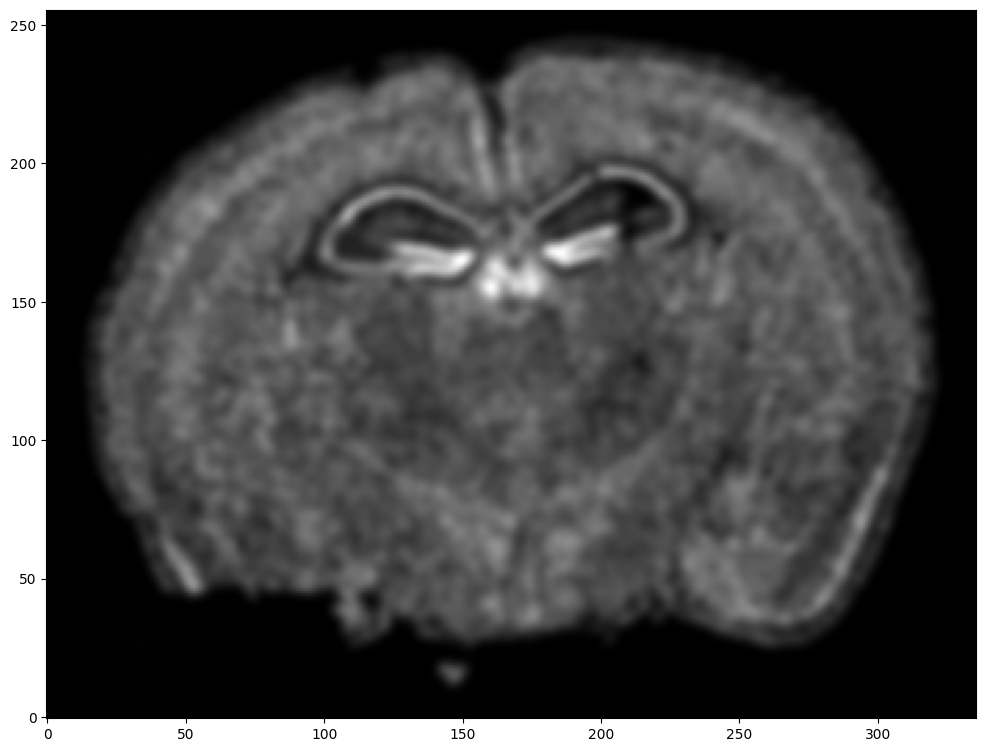

In [7]:
# rasterize at 30um resolution (assuming positions are in um units) and plot
XI,YI,I,fig = STalign.rasterize(xI, yI, dx=30)

ax = fig.axes[0]
ax.invert_yaxis()

Note that this is a 1D greyscale image. To align with an RGB H&E image, we will need to make our greyscale image into RGB by simply stacking the 1D values 3 times. We will also normalize to get intensity values between 0 to 1.

In [8]:
print("The initial shape of I is {}".format(I.shape))
I = np.vstack((I, I, I)) # make into 3xNxM
print("The range of I is {} to {}".format(I.min(), I.max() ))

# normalize
I = STalign.normalize(I)
print("The range of I after normalization is {} to {}".format(I.min(), I.max() ))

# double check size of things
print("The new shape of I is {}".format(I.shape))

The initial shape of I is (1, 256, 336)
The range of I is 0.0 to 4.715485184477206
The range of I after normalization is 0.0 to 1.0
The new shape of I is (3, 256, 336)


We have already downloaded the H&E staining image from https://www.10xgenomics.com/resources/datasets/adult-mouse-brain-ffpe-1-standard-1-3-0 and placed the file in a folder called `visium_data`

We can read in the H&E staining image using `matplotlib.pyplot` as `plt`. 

In [9]:
image_file = '../visium_data/tissue_hires_image.png'
V = plt.imread(image_file)

# plot
fig,ax = plt.subplots()
ax.imshow(V)

Note that this is an RGB image that `matplotlib.pyplot` had read in as an NxMx3 matrix with values ranging from 0 to 1. We will use `STalign` to normalize the image in case there are any outlier intensities. 

In [10]:
print("The initial shape of V is {}".format(V.shape))
print("The range of V is {} to {}".format(V.min(), V.max() ))

Vnorm = STalign.normalize(V)
print("The range of V after normalization is {} to {}".format(Vnorm.min(), Vnorm.max() ))

The initial shape of V is (2000, 1838, 3)
The range of V is 0.10588235408067703 to 1.0
The range of V after normalization is 0.0 to 1.0


We will transpose `Vnorm` to be a 3xNxM matrix `J` for downstream analyses. We will also create some variances `YJ` and `XJ` to keep track of the image size. 

In [11]:
J = Vnorm.transpose(2,0,1)
print("The new shape of J is {}".format(J.shape))

YJ = np.array(range(J.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = np.array(range(J.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.

The new shape of J is (3, 2000, 1838)


We now have a rasterized image corresponding to the single cell positions from the spatial transcriptomics data and an H&E image that we can align. Note, that we have specified the image from cell positions as source `I` and the H&E image as target `J` because the H&E image is only one hemisphere of the brain. We advise choosing the more complete tissue section as the source such that every observation in the target has some correspondence in the source.

Text(0.5, 1.0, 'target')

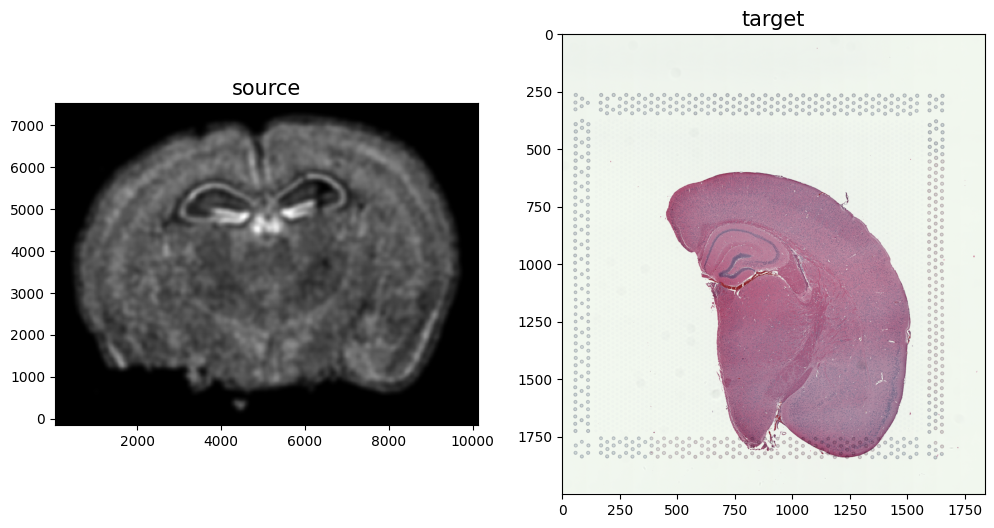

In [12]:
# plot
extentI = STalign.extent_from_x((YI,XI))

fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
ax[0].invert_yaxis()
ax[0].set_title('source', fontsize=15)
ax[1].imshow((J).transpose(1,2,0))
ax[1].set_title('target', fontsize=15)

`STalign` relies on an interative gradient descent to align these two images. This can be somewhat slow. We manually created 3 points that visually mark similar landmarks across the two datasets that we will use to initialize a simple affine alignment from the landmark points. 

We can double check that our landmark points look sensible by plotting them along with the rasterized image we created.

In [13]:
# manually make corresponding points
data = np.load('../visium_data/visium2_points.npz')
pointsI = np.array(data['pointsI'][...,::-1])
pointsJ = np.array(data['pointsJ'][...,::-1])
print(pointsI)
print(pointsJ)

[[5499.7972588  5095.02260152]
 [6628.02391148 4910.8223317 ]
 [7019.44948485 5463.42314117]
 [ 963.86561437 6937.02529977]
 [4901.14638187 5532.49824236]
 [4832.07128069 6131.14911929]
 [5131.39671915 6223.2492542 ]
 [5753.07262981 6154.17415302]
 [5246.52188779 6937.02529977]
 [5591.89739371 6683.74992876]
 [5269.54692152 5371.32300626]
 [ 641.51514218 8111.3020199 ]]
[[ 938.72950082  559.82404846]
 [ 788.82693749  463.88640793]
 [ 674.90098936  505.85912566]
 [1694.23842003  955.56681566]
 [1046.65934642  709.72661179]
 [1022.67493629  823.65255993]
 [ 956.71780842  799.66814979]
 [ 860.78016789  733.71102193]
 [ 962.71391096  949.57071313]
 [ 878.76847549  859.62917513]
 [1016.67883376  631.77727886]
 [1826.15267576 1267.3641474 ]]


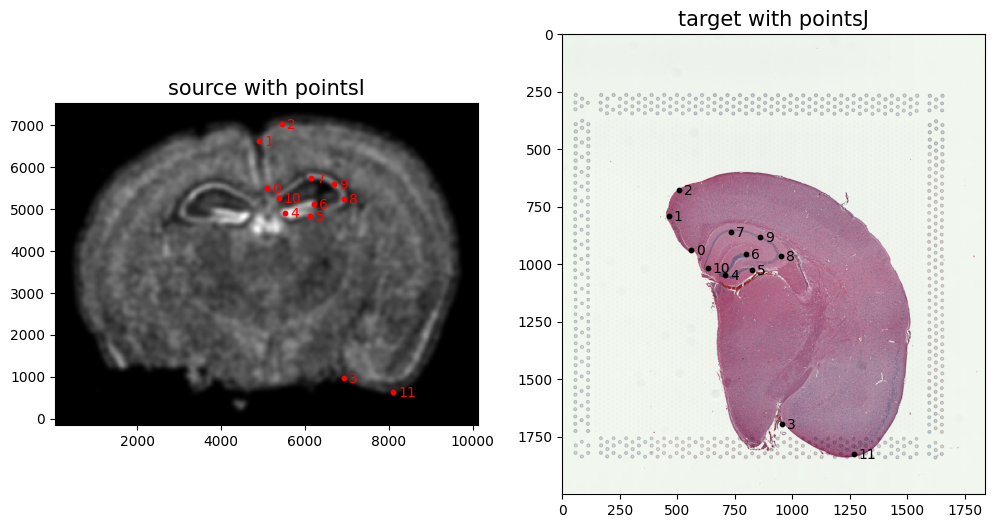

In [35]:
# plot
extentJ = STalign.extent_from_x((YJ,XJ))
extentI = STalign.extent_from_x((YI,XI))

fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)

trans_offset_0 = mtransforms.offset_copy(ax[0].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')
trans_offset_1 = mtransforms.offset_copy(ax[1].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')

ax[0].scatter(pointsI[:,1],pointsI[:,0], c='red', s=10)
ax[1].scatter(pointsJ[:,1],pointsJ[:,0], c='black', s=10)
for i in range(pointsI.shape[0]):
    ax[0].text(pointsI[i,1],pointsI[i,0],f'{i}', c='red', transform=trans_offset_0)
    ax[1].text(pointsJ[i,1],pointsJ[i,0],f'{i}', c='black', transform=trans_offset_1)

ax[0].set_title('source with pointsI', fontsize=15)
ax[1].set_title('target with pointsJ', fontsize=15)

# invert only rasterized image
ax[0].invert_yaxis()

From the landmark points, we can generate a linear transformation `L` and translation `T` which will produce a simple initial affine transformation `A`. 

In [36]:
# compute initial affine transformation from points
L,T = STalign.L_T_from_points(pointsI,pointsJ)
A = STalign.to_A(torch.tensor(L),torch.tensor(T))

We can show the results of the simple affine transformation.

In [37]:
# compute initial affine transformation from points
AI= STalign.transform_image_atlas_with_A(A, [YI,XI], I, [YJ,XJ])

# get extent of images
extentI = STalign.extent_from_x((YI,XI))
extentJ = STalign.extent_from_x((YJ,XJ))

fig,ax = plt.subplots(1,2)
#ax[0].imshow(AI[0], extent=extentI)
ax[0].imshow((AI.permute(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ) 

ax[0].set_title('source with affine transformation', fontsize=15)
ax[1].set_title('target', fontsize=15)

/Users/kalenclifton/STalign/docs/notebooks/../../STalign/STalign.py:1636: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)
/Users/kalenclifton/STalign/docs/notebooks/../../STalign/STalign.py:1649: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XJ = torch.tensor(XJ)


Text(0.5, 1.0, 'target')

In this case, we can observe that a simple affine alignment is not sufficient to align the single-cell spatial transcriptomics dataset to the H&E staining image. So we will need to perform non-linear local alignments via LDDMM. 

There are many parameters that can be tuned for performing this alignment. 

We will first select the parameters related to the Gaussian mixture model for classifying pixels as to be matched, in the background, or an artifact. 

Standard deviation of image matching term for Gaussian mixture modeling in cost function. 
        This term generally controls matching accuracy with smaller corresponding to more accurate.
        As an common example (rule of thumb), you could chose this parameter to be the variance of the pixels
        in your target image

In [59]:
fig,ax = plt.subplots()
ax.hist(I.ravel())
plt.xlabel('Intensity')
plt.ylabel('Number of Pixels')
plt.title('Intensity Histogram of Source Image')

Text(0.5, 1.0, 'Intensity Histogram of Source Image')

In [100]:
WM = torch.ones(I[0].shape)*0.5
WB = torch.ones(I[0].shape)*0.4
WA = torch.ones(I[0].shape)*0.1
muA = torch.sum(WA*I,dim=(-1,-2))/torch.sum(WA)
muB = torch.sum(WB*I,dim=(-1,-2))/torch.sum(WB)

In [101]:
print(muA)
print(muB)

tensor([0.2119, 0.2119, 0.2119], dtype=torch.float64)
tensor([0.2119, 0.2119, 0.2119], dtype=torch.float64)


In [151]:
#muB = np.mean(I)
#muB = 0

#print(np.var(I[I>muB]))
#print(np.std(I[I>muB]))

#print(len(I[I>muB]))
#print(len(I[I<=muB]))

#print("Set sigmaM to be {:.2f}". format(np.std(I[I>muB])))
#print("Set sigmaB to be {:.2f}". format(np.std(I[I<=muB])))

#print(np.var(I[I<=muB]))
#print(np.std(I[I<=muB]))

#print("Set sigmaM to be the variance, {:.2f}". format(np.var(I)))
print("Set sigmaM, sigmaB, and sigmaA to be the standard deviation, {:.2f}". format(np.std(I)))


Set sigmaM to be the variance, 0.03
Set sigmaM, sigmaB, and sigmaA to be the standard deviation, 0.18


Text(0.5, 1.0, 'Intensity Histogram of Target Image')

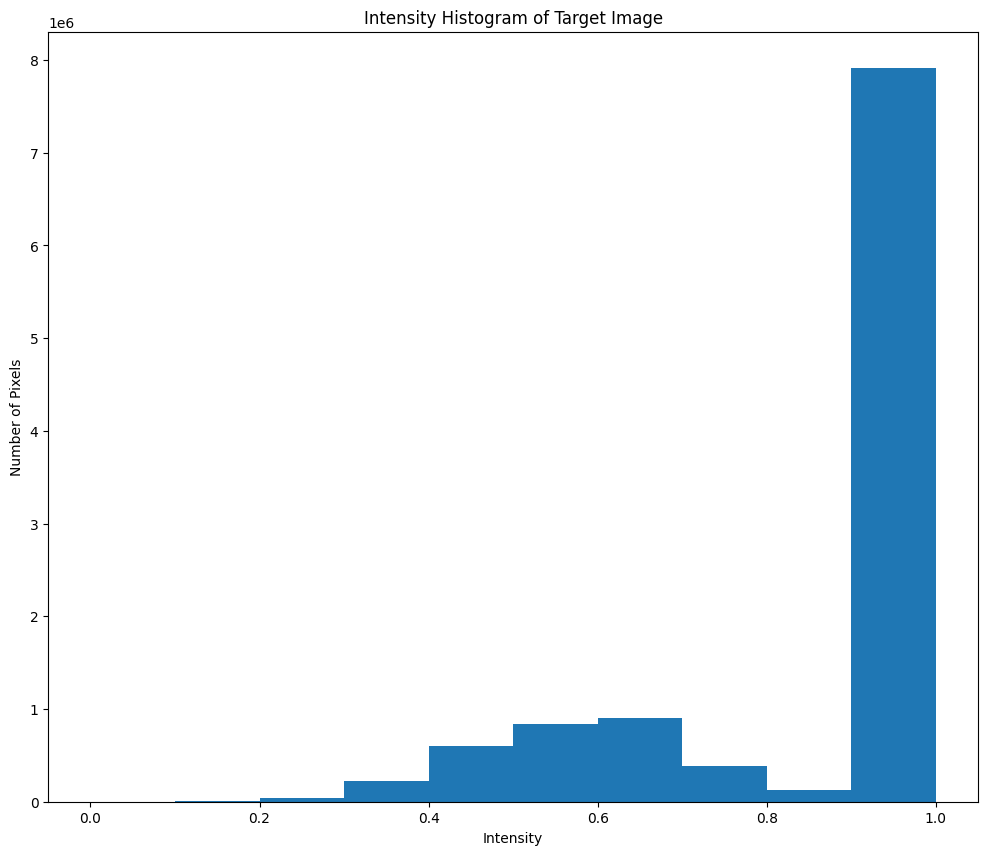

In [147]:
fig,ax = plt.subplots()
ax.hist(J.ravel())
plt.xlabel('Intensity')
plt.ylabel('Number of Pixels')
plt.title('Intensity Histogram of Target Image')

In [152]:
print("Set sigmaM, sigmaB, and sigmaA to be the standard deviation, {:.2f}". format(np.std(J)))

Set sigmaM, sigmaB, and sigmaA to be the standard deviation, 0.18


In [60]:
WM = torch.ones(J[0].shape)*0.5
WB = torch.ones(J[0].shape)*0.4
WA = torch.ones(J[0].shape)*0.1
muA = torch.sum(WA*J,dim=(-1,-2))/torch.sum(WA)
muB = torch.sum(WB*J,dim=(-1,-2))/torch.sum(WB)

In [62]:
print(muA)
print(muB)

tensor([0.8627, 0.8281, 0.8340])
tensor([0.8627, 0.8281, 0.8340])


In [63]:
WM = torch.ones(I[0].shape)*0.5
WB = torch.ones(I[0].shape)*0.4
WA = torch.ones(I[0].shape)*0.1
muA = torch.sum(WA*I,dim=(-1,-2))/torch.sum(WA)
muB = torch.sum(WB*I,dim=(-1,-2))/torch.sum(WB)

In [64]:
print(muA)
print(muB)

tensor([0.2119, 0.2119, 0.2119], dtype=torch.float64)
tensor([0.2119, 0.2119, 0.2119], dtype=torch.float64)


/Users/kalenclifton/STalign/docs/notebooks/../../STalign/STalign.py:1294: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')
/Users/kalenclifton/.local/share/virtualenvs/STalign-wXTCUYXW/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


CPU times: user 9min 3s, sys: 3min 49s, total: 12min 53s
Wall time: 5min 36s


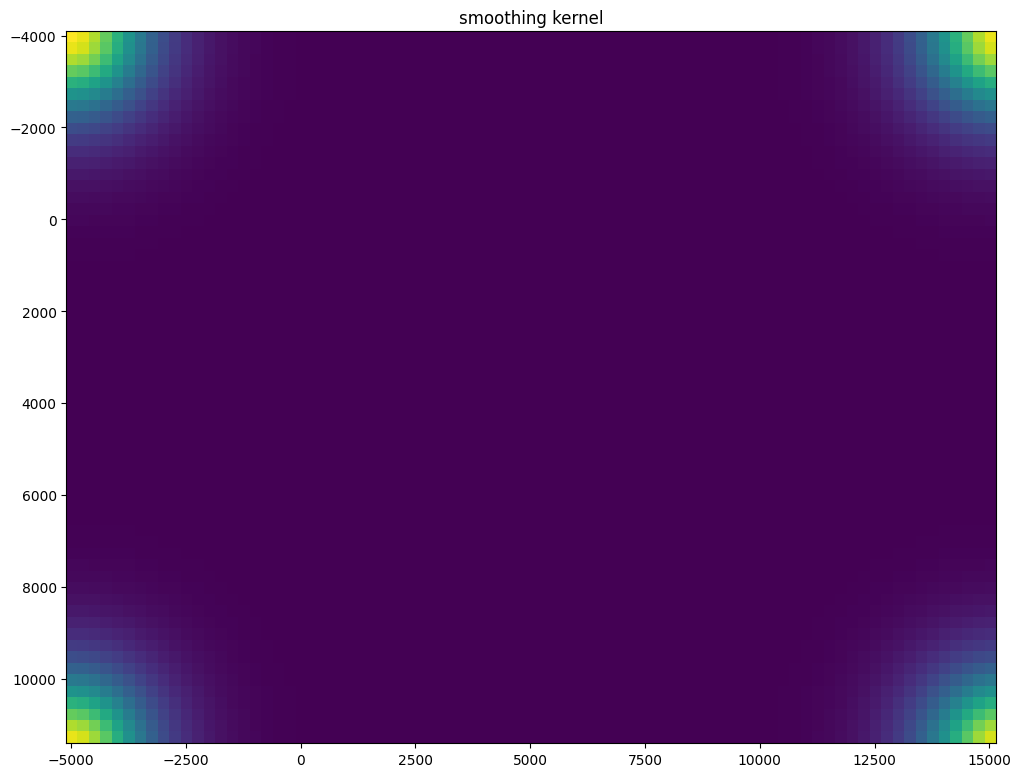

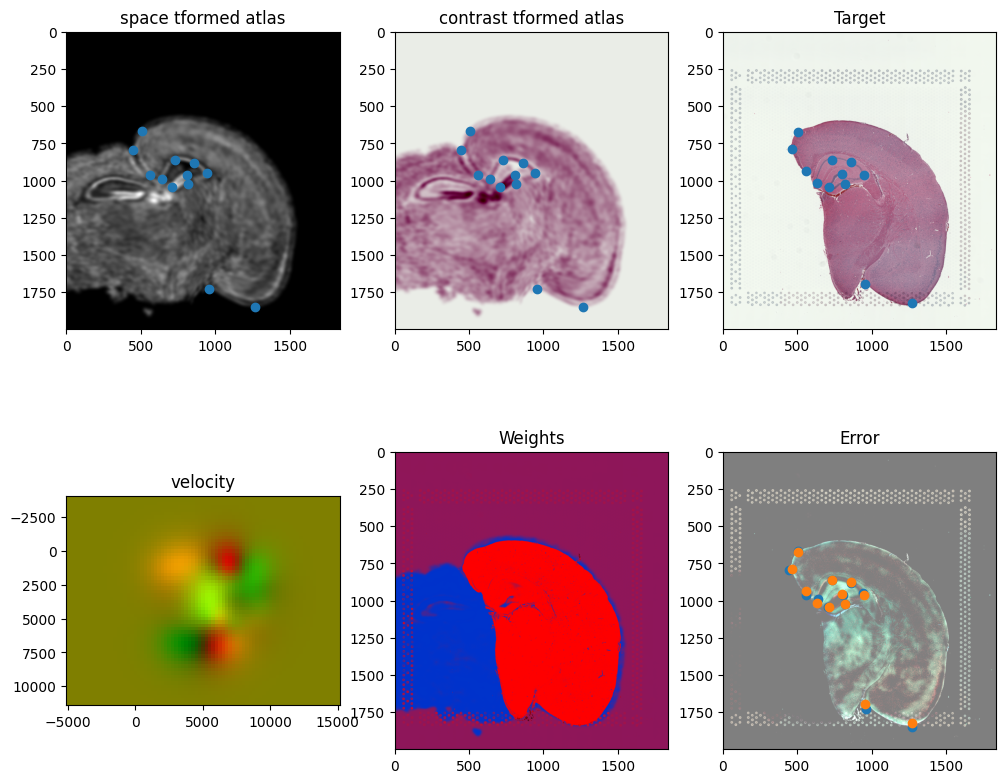

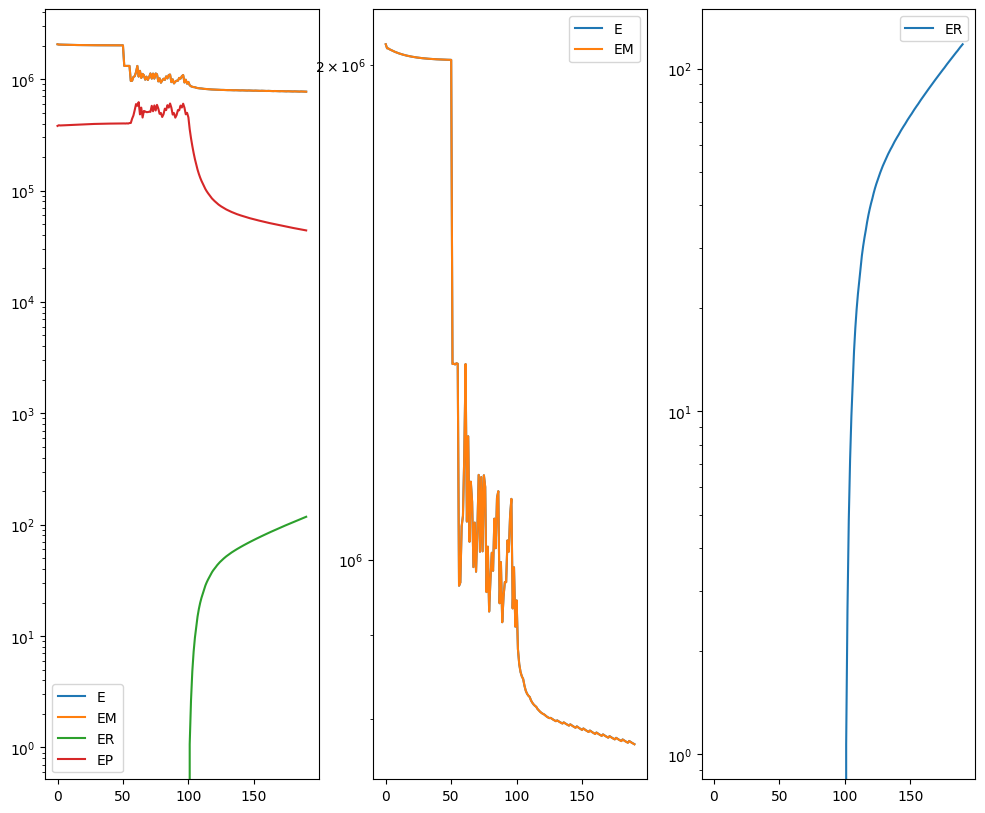

In [153]:
%%time

# run LDDMM
# running this on my desktop so cpu device
device = 'cpu' 

# keep all other parameters default
params = {'L':L,'T':T,
          'niter': 200,
          'pointsI': pointsI,
          'pointsJ': pointsJ,
          'device': device,
          'sigmaP': 2e-1,
          'sigmaM': 0.2,
          'sigmaB': 0.19, 
          'sigmaA': 0.3,
          'diffeo_start' : 100,
          'epL': 5e-11,
          'epT': 5e-4,
          'epV': 5e1
          }

# keep all other parameters default
params = {'L':L,'T':T,
          'niter': 200,
          'pointsI': pointsI,
          'pointsJ': pointsJ,
          'device': device,
          'sigmaP': 2e-1,
          'sigmaM': 0.18,
          'sigmaB': 0.18, 
          'sigmaA': 0.18,
          'diffeo_start' : 100,
          'epL': 5e-11,
          'epT': 5e-4,
          'epV': 5e1
          }

A,v,xv = STalign.LDDMM([YI,XI],I,[YJ,XJ],J,**params)

Plots generated throughout the alignment can be used to give you a sense of whether the parameter choices are appropriate and whether your alignment is converging on a solution.

We can also evaluate the resulting alignment by applying the transformation to visualize how our source and target images were deformed to achieve the alignment. 

In [154]:
# apply transform
phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = STalign.transform_image_atlas_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])
phiipointsI = STalign.transform_points_atlas_to_target(xv,v,A,pointsI)

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.scatter(phiipointsI[:,1].detach(),phiipointsI[:,0].detach(),c="m")

/Users/kalenclifton/STalign/docs/notebooks/../../STalign/STalign.py:1636: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)
/Users/kalenclifton/STalign/docs/notebooks/../../STalign/STalign.py:1637: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if v is not None: v = torch.tensor(v)
/Users/kalenclifton/STalign/docs/notebooks/../../STalign/STalign.py:1649: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XJ = torch.tensor(XJ)


Finally, we can apply our transform to the original sets of single cell centroid positions to achieve their new aligned positions.

In [155]:
# apply transform to original points
tpointsI= STalign.transform_points_atlas_to_target(xv,v,A, np.stack([yI, xI], 1))

#switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

And we can visualize the results.

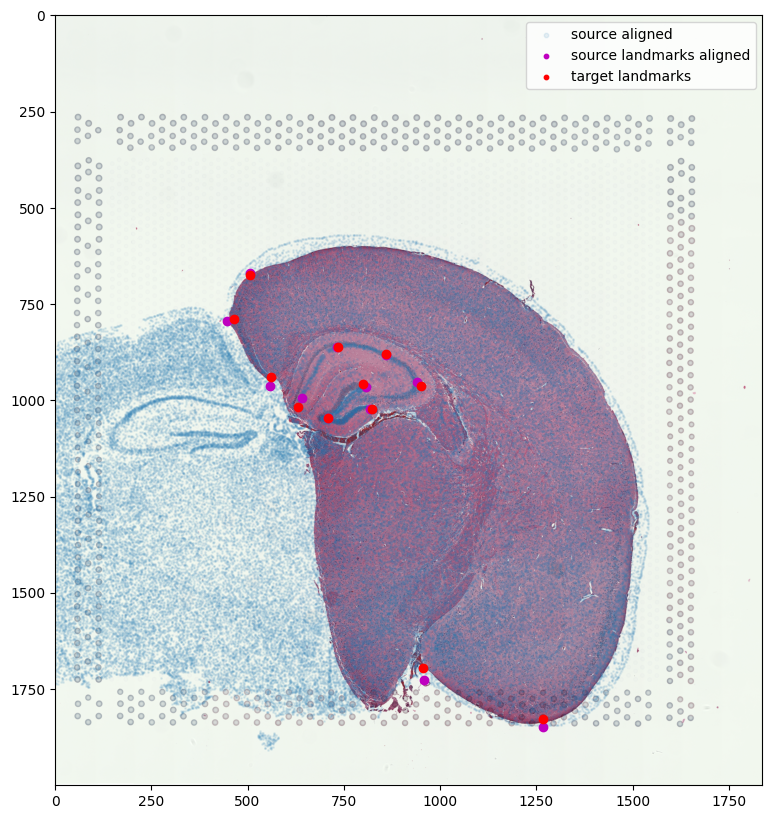

In [156]:
# plot
#fig,ax = plt.subplots()
#ax.imshow((I).transpose(1,2,0),extent=extentI)
#ax.scatter(phiipointsJ[:,1].detach(),phiipointsJ[:,0].detach(),c="r")
#ax.scatter(tpointsI[:,1].detach(),tpointsI[:,0].detach(),s=1,alpha=0.1)

# plot results
fig,ax = plt.subplots()
#ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(phiipointsI[:,1].detach(),phiipointsI[:,0].detach(),c="m", label='source landmarks aligned')
ax.scatter(pointsJ[:,1],pointsJ[:,0], c='red', label='target landmarks')
ax.imshow((J).transpose(1,2,0),extent=extentJ)

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])

And save the new aligned positions by appending to our original data

In [98]:
df3 = pd.DataFrame(

    {

        "aligned_x": xI_LDDMM,

        "aligned_y": yI_LDDMM,

    },


)

results = pd.concat([df1, df3], axis=1)
results.head()

Unnamed: 0  fov       volume    center_x   
0  158338042824236264719696604356349910479   33   532.778772  617.916619  \
1  260594727341160372355976405428092853003   33  1004.430016  596.808018   
2  307643940700812339199503248604719950662   33  1267.183208  578.880018   
3   30863303465976316429997331474071348973   33  1403.401822  572.616017   
4  313162718584097621688679244357302162401   33   507.949497  608.364018   

      center_y       min_x       max_x        min_y        max_y   aligned_x   
0  2666.520010  614.725219  621.108019  2657.545209  2675.494810 -302.602881  \
1  2763.450012  589.669218  603.946818  2757.013212  2769.886812 -309.432405   
2  2748.978012  570.877217  586.882818  2740.489211  2757.466812 -312.680962   
3  2766.690012  564.937217  580.294818  2756.581212  2776.798812 -314.414315   
4  2687.418010  603.061218  613.666818  2682.493210  2692.342810 -305.088868   

     aligned_y  
0  1549.061354  
1  1532.089346  
2  1535.168416  
3  1532.123275  
4  1545.535992

We will finally create a compressed `.csv.gz` file named `mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_STalign_to_Slice2_Replicate2.csv.gz`

In [99]:
results.to_csv('../merfish_data/mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_STalign_to_Visium_tissue_hires_image.csv.gz',
               compression='gzip')